---
# Plot distance to line-pRF on the surface

In [1]:
%matplotlib inline

In [2]:
from linescanning import (
    utils,
    plotting,
    prf,
)
import cortex
import matplotlib.pyplot as plt
import imageio
import numpy as np
import os
import pandas as pd
import pRFline
from pRFline import surface
from pRFline.utils import SubjectsDict
from linescanning import pycortex
import time
import seaborn as sns
opj = os.path.join
opd = os.path.dirname

230126-18:28:45,206 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.8.2


In [3]:
# set defaults
task        = "task-pRF"
base_dir    = "/data1/projects/MicroFunc/Jurjen/projects/VE-pRF"
prog_dir    = "/data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline"
design_dir  = opj(prog_dir, "data_lp3")
fig_dir     = opj(prog_dir, "results")

In [4]:
verbose = True
model = "gauss"

# fetch subject dictionary from pRFline.utils.SubjectsDict
subj_obj = SubjectsDict()
dict_data = subj_obj.dict_data

In [5]:
subj_obj.get_views("sub-002")

{'azimuth': 180, 'altitude': 105, 'radius': 163}

## Do stuff for 1 subject

In [6]:
subject = "sub-005"
ses = subj_obj.get_session(subject)
views = subj_obj.get_views(subject)

# initiate class
sg = surface.DistSurf(
    subject=subject,
    hemi="lh",
    verbose=True,
    azimuth=views["azimuth"],
    altitude=views["altitude"],
    radius=views["radius"]
)
    
# line pRF
rf_dir = opj(os.environ.get("DIR_DATA_DERIV"), "prf", subject)
pars_file = opj(
    rf_dir, 
    f"ses-{ses}",
    f"{subject}_ses-{ses}_task-pRF_run-avg_vox-ribbon_model-gauss_stage-iter_desc-prf_params.pkl")

# EPI pRFs
epi_file = opj(
    rf_dir,
    "ses-1",
    f"{subject}_ses-1_task-2R_roi-V1_model-{model}_stage-iter_desc-prf_params.pkl")

sg.read_files(
    epi=epi_file,
    line=pars_file
)

Initializing SurfaceCalc
Creating subsurfaces for V1_exvivo.thresh
Target vertex '6055' is at index '1158' in subsurface
Finding distances from V1_exvivo.thresh to vertex #1158
Reading pRF-estimate files
 epi: '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/prf/sub-005/ses-1/sub-005_ses-1_task-2R_roi-V1_model-gauss_stage-iter_desc-prf_params.pkl'
 line: '/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/prf/sub-005/ses-3/sub-005_ses-3_task-pRF_run-avg_vox-ribbon_model-gauss_stage-iter_desc-prf_params.pkl'


In [33]:
sg.find_distance(
    smooth=True, 
    kernel=1,
    iterations=1)

Target vertex was '6055'
Smallest difference = 0.02dva (vertex='7014')
Geodesic distance '7014' to '6055' = 4.64mm [unsmoothed]
Euclidian distance '7014' to '6055' = 4.56mm [unsmoothed]
Smoothing distance map with 'factor=1' & 'iterations=1'
Smallest difference = 0.02dva (vertex='6137')
Geodesic distance '6137' to '6055' = 7.94mm [smoothed]
Euclidian distance '6137' to '6055' = 5.79mm [smoothed]


In [43]:
sg.make_vertex(one_hemi=True)

Updating 'one_hemi' from 'True' to 'True'


In [44]:
sg.webshow()

Started server on port 44949
Stopping server


In [66]:
pyc_save = pycortex.SavePycortexViews(
    data_d,
    subject=subject,
    fig_dir=opj(fig_dir,subject),
    zoom=True)

# time.sleep(3)
# pyc_save.save_all()

Started server on port 45941
Stopping server


In [12]:
fix_2d = pycortex.Vertex2D_fix(
    sg.dist_array_sm,
    sg.whole_roi.astype(int),
    "sub-001",
    "magma_r",
    vmin=0,
    vmax=4,
    vmin2=0,
    vmax2=1)

cortex.webgl.show({"dist": fix_2d})

Started server on port 29618
Stopping server


<JS: window.viewer>

In [28]:
cortex.webgl.show({"curv": fix_2d})

Started server on port 54648
Stopping server


<JS: window.viewer>

## Loop through subjects

In [156]:
distsurf = {}
for ii in ["subject","distance","distance_type","model","model_type","smooth","dva","obj"]:
    distsurf[ii] = []

process_subjs = list(dict_data.keys())
# process_subjs = ["sub-001"]
for subject in process_subjs:
    utils.verbose(f"\n**************************************** Processing {subject} ***************************************", verbose=True)    
    utils.verbose(f"Initializing surface classes", verbose=verbose)
    sg = surface.DistSurf(
        subject=subject,
        hemi="lh",
        verbose=False
    )

    for m_ix,model in enumerate(["gauss","norm"]):
        utils.verbose(f"Model = {model}", verbose=verbose)

        # line pRF
        data_output = opj(design_dir, subject)
        pars_file = opj(data_output, f"{subject}_acq-lines_res-native_vox-avg_model-{model}_stage-iter_desc-prf_params.pkl")
        
        # EPI pRFs
        epi_file = opj(
            os.environ.get("DIR_DATA_DERIV"),
            "prf",
            subject,
            "ses-1",
            f"{subject}_ses-1_task-2R_roi-V1_model-{model}_stage-iter_desc-prf_params.pkl")

        sg.read_files(
            epi=epi_file,
            line=pars_file
        )

        for sm_ix,sm in enumerate([0,1,2,3]):
            utils.verbose(f"  Smoothing = {sm}..", verbose=verbose)

            if sm == 0:
                smooth = False
            else:
                smooth = True

            sg.find_distance(
                smooth=smooth, 
                kernel=sm,
                iterations=1)

            sg.make_vertex()

            # append to list
            for dist in ["geodesic","euclidian"]:
                
                # append smoothed value if smooth==True
                if smooth:
                    app_dist = getattr(sg, f"dist_{dist}_sm")
                else:
                    app_dist = getattr(sg, f"dist_{dist}")
                    
                distsurf["subject"].append(subject)
                distsurf["distance"].append(app_dist)
                distsurf["distance_type"].append(dist)
                distsurf["model"].append(m_ix)
                distsurf["model_type"].append(model)
                distsurf["smooth"].append(sm)
                distsurf["dva"].append(sg.dva_dist)
                distsurf["obj"].append(sg)


**************************************** Processing sub-001 ***************************************
Initializing surface classes
Model = gauss
  Smoothing = 0..
  Smoothing = 1..
  Smoothing = 2..
  Smoothing = 3..
Model = norm
  Smoothing = 0..
  Smoothing = 1..
  Smoothing = 2..
  Smoothing = 3..

**************************************** Processing sub-002 ***************************************
Initializing surface classes
Model = gauss
  Smoothing = 0..
  Smoothing = 1..
  Smoothing = 2..
  Smoothing = 3..
Model = norm
  Smoothing = 0..
  Smoothing = 1..
  Smoothing = 2..
  Smoothing = 3..

**************************************** Processing sub-003 ***************************************
Initializing surface classes
Model = gauss
  Smoothing = 0..
  Smoothing = 1..
  Smoothing = 2..
  Smoothing = 3..
Model = norm
  Smoothing = 0..
  Smoothing = 1..
  Smoothing = 2..
  Smoothing = 3..

**************************************** Processing sub-005 ************************************

In [199]:
df_surf2 = pd.DataFrame(distsurf)
df_surf2.head()

,subject,distance,distance_type,model,model_type,smooth,dva,obj
0,sub-001,5.350559,geodesic,0,gauss,0,0.035297,<pRFline.surface.DistSurf object at 0x7f8de80d...
1,sub-001,4.597867,euclidian,0,gauss,0,0.035297,<pRFline.surface.DistSurf object at 0x7f8de80d...
2,sub-001,2.857507,geodesic,0,gauss,1,0.718605,<pRFline.surface.DistSurf object at 0x7f8de80d...
3,sub-001,2.927873,euclidian,0,gauss,1,0.718605,<pRFline.surface.DistSurf object at 0x7f8de80d...
4,sub-001,3.323170,geodesic,0,gauss,2,0.928980,<pRFline.surface.DistSurf object at 0x7f8de80d...


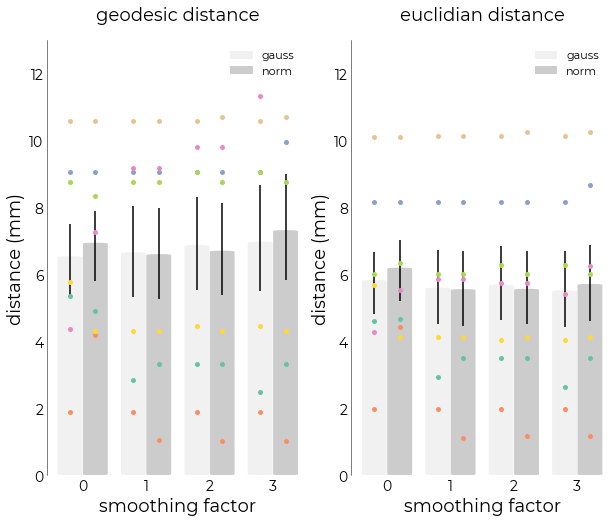

In [198]:
fig,axs = plt.subplots(ncols=2, figsize=(10,8))

for ix,dist in enumerate(["geodesic","euclidian"]):
    plotting.LazyBar(
        data=utils.select_from_df(df_surf2, expression=f"distance_type = {dist}"),
        x="smooth",
        y="distance",
        sns_ori="v",
        axs=axs[ix],
        sns_offset=4,
        color="#cccccc",
        add_points=True,
        add_labels=True,
        bar_legend=True,
        hue="model_type",
        points_cmap="Set2",
        points_hue="subject",    
        y_label2=f"distance (mm)",
        fancy=True,
        trim_bottom=True,
        lim=[0,13],
        x_label2="smoothing factor",
        error="sem",
        title2=f"{dist} distance"
    )

In [201]:
utils.select_from_df(df_surf2, expression="subject = sub-005")

,index,subject,distance,distance_type,model,model_type,smooth,dva,obj
48,48,sub-005,4.375578,geodesic,0,gauss,0,0.031728,<pRFline.surface.DistSurf object at 0x7f8de817...
49,49,sub-005,4.297080,euclidian,0,gauss,0,0.031728,<pRFline.surface.DistSurf object at 0x7f8de817...
50,50,sub-005,9.184164,geodesic,0,gauss,1,0.174182,<pRFline.surface.DistSurf object at 0x7f8de817...
51,51,sub-005,5.870098,euclidian,0,gauss,1,0.174182,<pRFline.surface.DistSurf object at 0x7f8de817...
52,52,sub-005,9.811669,geodesic,0,gauss,2,0.213184,<pRFline.surface.DistSurf object at 0x7f8de817...
53,53,sub-005,5.753901,euclidian,0,gauss,2,0.213184,<pRFline.surface.DistSurf object at 0x7f8de817...
54,54,sub-005,11.347352,geodesic,0,gauss,3,0.242542,<pRFline.surface.DistSurf object at 0x7f8de817...
55,55,sub-005,5.412472,euclidian,0,gauss,3,0.242542,<pRFline.surface.DistSurf object at 0x7f8de817...
56,56,sub-005,7.271748,geodesic,1,norm,0,0.020936,<pRFline.surface.DistSurf object at 0x7f8de817...
57,57,sub-005,5.535060,euclidian,1,norm,0,0.020936,<pRFline.surface.DistSurf object at 0x7f8de817...


In [192]:
pl.data.groupby(["model_type","smooth"]).sem()["distance"].values.reshape(2,4)

array([[1.00876665, 1.08892052, 1.06340757, 1.11150725],
       [0.83683149, 1.13572826, 1.14002884, 1.17307076]])

In [203]:
df_surf2[[ii for ii in list(df_surf2.keys()) if ii != "obj"]]

,subject,distance,distance_type,model,model_type,smooth,dva
0,sub-001,5.350559,geodesic,0,gauss,0,0.035297
1,sub-001,4.597867,euclidian,0,gauss,0,0.035297
2,sub-001,2.857507,geodesic,0,gauss,1,0.718605
3,sub-001,2.927873,euclidian,0,gauss,1,0.718605
4,sub-001,3.323170,geodesic,0,gauss,2,0.928980
...,...,...,...,...,...,...,...
107,sub-009,10.141514,euclidian,1,norm,1,0.391601
108,sub-009,10.703817,geodesic,1,norm,2,0.451762
109,sub-009,10.259044,euclidian,1,norm,2,0.451762
110,sub-009,10.703817,geodesic,1,norm,3,0.487703


In [204]:
df_surf3 = df_surf2[[ii for ii in list(df_surf2.keys()) if ii != "obj"]]
fname = opj(fig_dir, "distance_on_surface_smoothing.csv")
if not os.path.exists(fname):
    utils.verbose(f"Writing {fname}", verbose=verbose)
    df_surf3.to_csv(fname)

Writing /data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/results/distance_on_surface_smoothing.csv


In [87]:
df_surf

,subject,geodesic,euclidian,dva,ix
0,sub-001,5.350559,4.597867,0.035297,0
1,sub-002,1.900829,1.976080,0.121397,0
2,sub-003,9.063385,8.181613,0.040337,0
3,sub-005,4.375578,4.297080,0.031728,0
4,sub-007,8.761484,6.008224,0.223421,0
5,sub-008,5.790199,5.698620,0.086383,0
6,sub-009,10.593144,10.124252,0.125786,0


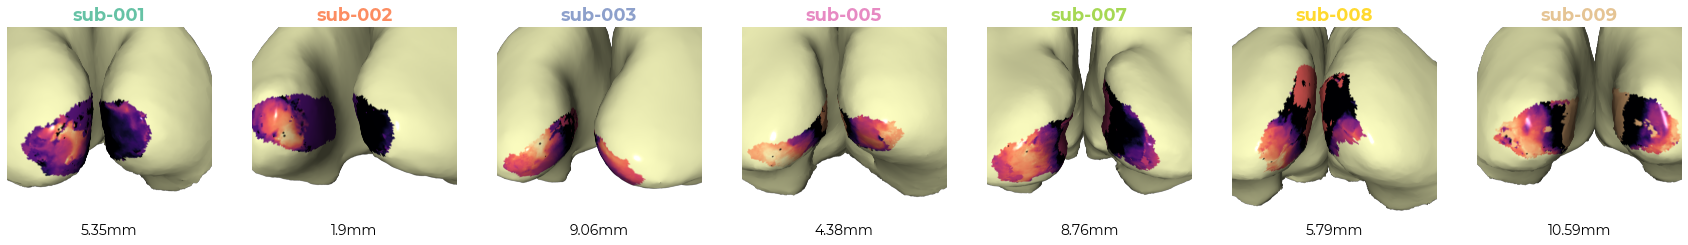

In [47]:
cmap_subj = "Set2"
process_subjs = ['']
sub_colors = sns.color_palette(cmap_subj, len(process_subjs))

fig,axs = plt.subplots(ncols=len(process_subjs), figsize=(30,5))
for ix,subject in enumerate(process_subjs):
    fn_image = opj(fig_dir, subject, f"{subject}_desc-distance_to_line.png")

    im = imageio.imread(fn_image)
    axs[ix].imshow(im)
    axs[ix].set_title(
        subject, 
        fontsize=18, 
        fontname="Montserrat",
        color=sub_colors[ix], 
        fontweight="bold")

    dist = df_surf.loc[df_surf["subject"] == subject]["mm"].values[0]
    axs[ix].annotate(
        f"{round(dist,2)}mm", 
        (0.5,0), 
        va="center",
        ha="center",
        fontsize=14, 
        fontname="Montserrat",
        xycoords="axes fraction")

    axs[ix].axis('off')

# fname = opj(fig_dir, f"sub-all_model-{model}_desc-distance_to_line")
# for ext in ['png','svg']:
#     fig.savefig(
#         f"{fname}.{ext}",
#         bbox_inches="tight",
#         dpi=300,
#         facecolor="white"
#     )

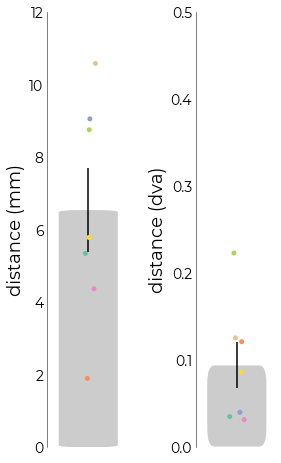

In [74]:
fig,axs = plt.subplots(ncols=2, figsize=(4,8), gridspec_kw={"wspace":0.99})

for ix,par in enumerate(["mm","dva"]):

    if par == "mm":
        y_lim = [0,12]
        rdn = 0.3
    else:
        y_lim = [0,0.5]
        rdn = 0.1
    
    ax = axs[ix]
    plotting.LazyBar(
        data=df_surf,
        x="ix",
        y=par,
        sns_ori="v",
        axs=ax,
        sns_offset=4,
        color="#cccccc",
        add_points=True,
        points_cmap="Set2",
        points_hue="subject",    
        y_label2=f"distance ({par})",
        fancy=True,
        fancy_rounding=rdn,
        lim=y_lim,
        trim_bottom=True
    )